### Machine Learning for Codon Usage Classification

In [2]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor

# Metric tools, and utility methods
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report,accuracy_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV

### Preparing the Data

In [3]:
df = pd.read_csv('../raw_data/codon_usage.csv')

df['Kingdom'] = df['Kingdom'].astype('category')
df['Kingdom_Code'] = df['Kingdom'].cat.codes

codon_df = df.loc[:,df.columns[6:]]

# There is a string data on position 5063, so we need to drop it:
codon_df = codon_df.drop([5063])
codon_df = codon_df.apply(pd.to_numeric)
print(codon_df.head())

       UUC      UUA      UUG      CUU      CUC      CUA      CUG      AUU  \
0  0.01203  0.00050  0.00351  0.01203  0.03208  0.00100  0.04010  0.00551   
1  0.01357  0.00068  0.00678  0.00407  0.02849  0.00204  0.04410  0.01153   
2  0.02180  0.01357  0.01543  0.00782  0.01111  0.01028  0.01193  0.02283   
3  0.02245  0.01619  0.00992  0.01567  0.01358  0.00940  0.01723  0.02402   
4  0.01371  0.00767  0.03679  0.01380  0.00548  0.00473  0.02076  0.02716   

       AUC      AUA  ...      AGA      AGG      GAU      GAC      GAA  \
0  0.02005  0.00752  ...  0.01303  0.03559  0.01003  0.04612  0.01203   
1  0.02510  0.00882  ...  0.01696  0.03596  0.01221  0.04545  0.01560   
2  0.01604  0.01316  ...  0.01974  0.02489  0.03126  0.02036  0.02242   
3  0.02245  0.02507  ...  0.01410  0.01671  0.03760  0.01932  0.03029   
4  0.00867  0.01310  ...  0.01494  0.01734  0.04148  0.02483  0.03359   

       GAG      UAA      UAG      UGA  Kingdom_Code  
0  0.04361  0.00251  0.00050  0.00000       

/tmp/ipykernel_260436/964674226.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../raw_data/codon_usage.csv')


 Renaming the kingdoms and dna names later for  clarity of visualization. References of these values were gathered in the UCI Repository dataset description.

In [4]:
#References in dictionary

K_names2 = {0: 'archaea',
            1: ' bacteria',
            2 : 'bacteriophage',
            3: 'plasmid',
            4: 'plant',
            5: 'invertebrate',
            6: 'vertebrate',
            7: 'mammal',
            8: 'rodent',
            9: 'primate', 
            10: 'virus'} 

DNA_names = {0:'genomic',
           1:'mitochondrial', 
           2:'chloroplast', 
           3:'cyanelle', 
           4:'plastid', 
           5:'nucleomorph', 
           6:'secondary_endosymbiont', 
           7:'chromoplast', '8':'leucoplast', 
           9:'NA',
           10:'proplastid',
           11:'apicoplast', 
           12:'kinetoplast'}

### Predicting Kingdom Category Based on Codon Frequency

In [5]:
X = codon_df.iloc[:,:-1]
y = codon_df['Kingdom_Code']

## Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify = y)

### K Nearest Neighbor Model

In [6]:
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(knn.score(X_test, y_test))

[[ 21   3   0   0   0   0   0   0   0   1   0]
 [  1 565   5   0   3   0   8   0   0   2   0]
 [  0  11 225   1   1   0  17   0   0   6   8]
 [  0   0   2  97   0   0   0   2   5   3   5]
 [  1   9   0   0  33   0   1   0   0   0   0]
 [  0   3   0   0   1   0   0   0   0   0   0]
 [  0  11   9   0   0   0 477   1   1   4   2]
 [  0   0   0   7   0   0   0  26   1   0   2]
 [  0   0   0  11   0   0   0   4  27   0   1]
 [  0   5   6   3   0   0  32   0   1 518   2]
 [  0   1   4   3   0   0   0   3   6   0 398]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.93      0.97      0.95       584
           2       0.90      0.84      0.87       269
           3       0.80      0.85      0.82       114
           4       0.87      0.75      0.80        44
           5       0.00      0.00      0.00         4
           6       0.89      0.94      0.92       505
           7       0.72      0.72      0.72      

In [7]:
# Test Evaluation
test_df = pd.DataFrame([y_test.tolist(), y_pred.tolist()])
test_df = test_df.transpose()

test_df = test_df.rename(columns = { 0: "y_test", 1: "y_predict"})
test_df['Check'] = np.where(test_df['y_test'] == test_df['y_predict'], 1, 0)


total_test_case = test_df.Check.count()
correct_test_predict = test_df.value_counts('Check')[1]
incorrect_test_predict = test_df.value_counts('Check')[0]

print("Number of All Test Cases: {}".format(total_test_case))

print("Number of Correct Prediction: {}".format(correct_test_predict))

print("Number of Incorrect Prediction: {}".format(incorrect_test_predict))

Number of All Test Cases: 2606
Number of Correct Prediction: 2387
Number of Incorrect Prediction: 219


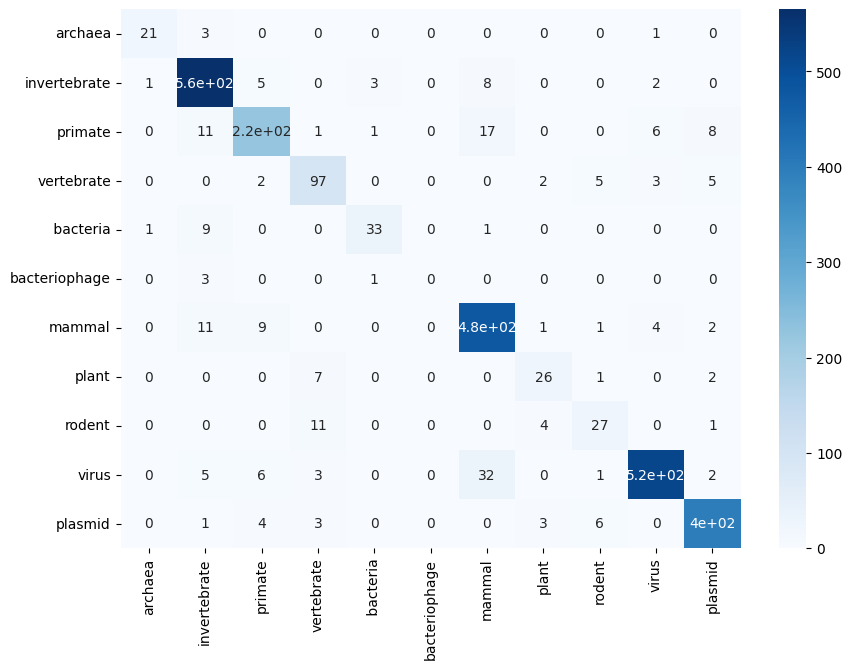

In [8]:
DNA_Types = []

for item in y_test.unique():
    DNA_Types.append(K_names2[item])

for item in y_pred:
    DNA_Types.append(K_names2[item])

DNA_Types = list(set(DNA_Types))

knn_array = confusion_matrix(y_test, y_pred)
df_knn_confusion = pd.DataFrame(knn_array, 
    index = [i for i in DNA_Types],
    columns = [i for i in DNA_Types]
)

plt.figure(figsize = (10,7))
sns.heatmap(df_knn_confusion, annot=True, cmap='Blues')
plt.show()

### Random Forest Classifier Model

In [9]:
rfc = RandomForestClassifier()

ada_rf = AdaBoostClassifier(estimator=rfc, n_estimators= 180, random_state= 1)

ada_rf.fit(X_train, y_train)

y_pred = ada_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(knn.score(X_test, y_test))

[[ 10  10   0   0   0   0   3   0   0   2   0]
 [  1 568   3   0   0   0  10   0   0   2   0]
 [  0  17 197   0   0   0  21   0   0  29   5]
 [  0   0   1  91   0   0   0   1   1   1  19]
 [  1  16   0   0  22   0   1   0   0   4   0]
 [  0   4   0   0   0   0   0   0   0   0   0]
 [  0  13   7   0   0   0 471   0   0  14   0]
 [  0   0   0   7   0   0   0  20   0   0   9]
 [  0   0   0   6   0   0   0   1  23   1  12]
 [  0   4   2   0   0   0  12   0   0 547   2]
 [  0   0   6   0   0   0   1   0   0   7 401]]
              precision    recall  f1-score   support

           0       0.83      0.40      0.54        25
           1       0.90      0.97      0.93       584
           2       0.91      0.73      0.81       269
           3       0.88      0.80      0.83       114
           4       1.00      0.50      0.67        44
           5       0.00      0.00      0.00         4
           6       0.91      0.93      0.92       505
           7       0.91      0.56      0.69      

In [10]:
#Test Evaluation
test_df = pd.DataFrame([y_test.tolist(), y_pred.tolist()])
test_df = test_df.transpose()

test_df = test_df.rename(columns = { 0: "y_test", 1: "y_predict"})
test_df['Check'] = np.where(test_df['y_test'] == test_df['y_predict'], 1, 0)


total_test_case = test_df.Check.count()
correct_test_predict = test_df.value_counts('Check')[1]
incorrect_test_predict = test_df.value_counts('Check')[0]

print("Number of All Test Cases: {}".format(total_test_case))

print("Number of Correct Prediction: {}".format(correct_test_predict))

print("Number of Incorrect Prediction: {}".format(incorrect_test_predict))

Number of All Test Cases: 2606
Number of Correct Prediction: 2350
Number of Incorrect Prediction: 256


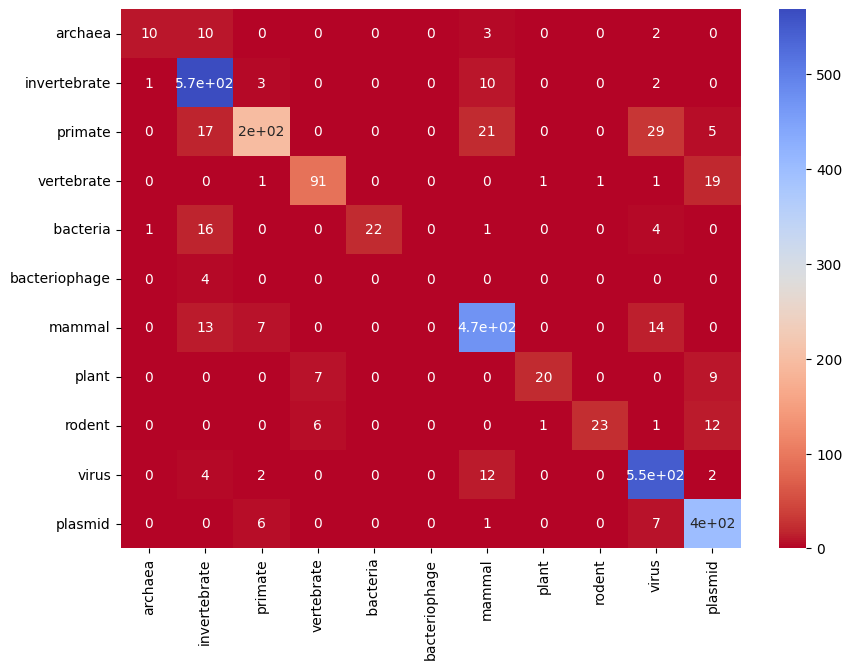

In [11]:
DNA_Types = []

for item in y_test.unique():
    DNA_Types.append(K_names2[item])

for item in y_pred:
    DNA_Types.append(K_names2[item])

DNA_Types = list(set(DNA_Types))

rfc_array = confusion_matrix(y_test, y_pred)
df_rfc_confusion = pd.DataFrame(rfc_array, 
    index = [i for i in DNA_Types],
    columns = [i for i in DNA_Types]
)

plt.figure(figsize = (10,7))
sns.heatmap(df_rfc_confusion, annot=True, cmap='coolwarm_r')
plt.show()

### Decision Tree Classifier Model

In [14]:
dt = DecisionTreeClassifier(random_state= 1)

ada_dt = AdaBoostClassifier(estimator=dt, random_state = 1)

ada_dt.fit(X_train, y_train)

y_pred = ada_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(knn.score(X_test, y_test))

[[ 11   4   2   0   1   0   3   0   0   4   0]
 [  7 492  26   1  10   1  26   0   0  19   2]
 [  0  24 164   3   9   0  37   0   0  26   6]
 [  0   0   1  74   0   0   1   4   8   5  21]
 [  1   9   1   0  22   2   4   0   0   4   1]
 [  0   4   0   0   0   0   0   0   0   0   0]
 [  2  18  26   1   7   0 405   3   0  38   5]
 [  0   0   0   7   0   0   0  13   5   1  10]
 [  0   0   0  10   0   0   0   5  22   1   5]
 [  2  26  39   3   3   0  40   3   2 443   6]
 [  0   1  13   8   1   0   8  12   4  10 358]]
              precision    recall  f1-score   support

           0       0.48      0.44      0.46        25
           1       0.85      0.84      0.85       584
           2       0.60      0.61      0.61       269
           3       0.69      0.65      0.67       114
           4       0.42      0.50      0.45        44
           5       0.00      0.00      0.00         4
           6       0.77      0.80      0.79       505
           7       0.33      0.36      0.34      

In [15]:
#Test Evaluation
test_df = pd.DataFrame([y_test.tolist(), y_pred.tolist()])
test_df = test_df.transpose()

test_df = test_df.rename(columns = { 0: "y_test", 1: "y_predict"})
test_df['Check'] = np.where(test_df['y_test'] == test_df['y_predict'], 1, 0)


total_test_case = test_df.Check.count()
correct_test_predict = test_df.value_counts('Check')[1]
incorrect_test_predict = test_df.value_counts('Check')[0]

print("Number of All Test Cases: {}".format(total_test_case))

print("Number of Correct Prediction: {}".format(correct_test_predict))

print("Number of Incorrect Prediction: {}".format(incorrect_test_predict))

Number of All Test Cases: 2606
Number of Correct Prediction: 2004
Number of Incorrect Prediction: 602


In [ ]:
DNA_Types = []

for item in y_test.unique():
    DNA_Types.append(K_names2[item])

for item in y_pred:
    DNA_Types.append(K_names2[item])

DNA_Types = list(set(DNA_Types))

dt_array = confusion_matrix(y_test, y_pred)
df_dt_confusion = pd.DataFrame(dt_array, 
    index = [i for i in DNA_Types],
    columns = [i for i in DNA_Types]
)

plt.figure(figsize = (10,7))
sns.heatmap(df_dt_confusion, annot=True, cmap='viridis')
plt.show()